In [ ]:
#Final Project
#AAI-520 

#Callum Lamb - Team Leader
#Deepti Pamula
#Jack Baxter
#Jasper Dolar

In [ ]:
#Cell 0

#Project Description — What this project does

#This notebook builds an autonomous investment research 
#agent that researches a stock end-to-end.
#It dynamically routes user requests to the right tools 
#(web search, price lookup, daily trend, and news analysis), 
#runs a prompt-chained NLP pipeline on recent news 
#(preprocess → VADER sentiment → Hugging Face NER → summary), 
#and then self-evaluates the write-up with a tiny LLM grader.
#The agent keeps memory across turns via LangGraph’s MemorySaver 
#(thread_id), so preferences like a watchlist persist within 
#a session. 
# 
#Demos show Q&A, a compact news brief, and a sentiment
#plot—covering the rubric’s Agent Functions and Workflow Patterns.

#Project Requirements / Rubric Map
#--------------------------
#Agent Functions (33.8%)
#- Dynamic tool use & planning 
#  Cells 7, 8, 15

#- Self-reflection / evaluation 
#  Cell 11 (optimize_news -> score 0–4)

#- Learns across runs (memory) 
#  Cells 8–9 (MemorySaver + thread_id)
#

#--------------------------
#Workflow Patterns (33.8%)
#1) Prompt Chaining 
#   (ingest→preprocess→classify→extract→summarize)
#   Cells 10–11, 13

#2) Routing (send to the right tool)
#   Cells 7–8, 15 (with demos in 9, 14–15)

#3) Evaluator–Optimizer
#   Cell 11 (score); comments describe refinement logic
#   - see optional Cell 16a for auto-refinement demo

#Code (32.4%)
#Submitted in PDF
#Relevant inline comments included
#GitHub repository link included

#------------------------
# Technology Requirements - with APIs
# - Yahoo Finance (yfinance) 
#   Cells 7, 10, 13

# - Tavily (web search) 
#   Cell 5
# - Finnhub (company news) 
#   Cells 7, 13
# - Alpha Vantage (daily series) 
#   Cell 7
#

#------------------------
# Deliverable Evidence
# - Design/Workflows/Capabilities 
#   Inline comments (Cells 7–8, 10–11, 15)

# - Demos & outputs 
#   Cells 9, 12, 14, 15

# - Evaluation score printed 
#   Cells 12, 13, 15
# - Viz (optional polish) 
#   Cell 17

#-----------------------
# Run order:
# 0 → 1 → 2 → 3 → (3b if first setup) → 4 → 5 → 7 
# → 8 → 9 → 10 → 11 → 12 → 13 → (16a optional) 
# → 14 → 15 → 17

# Optional: 
# Cell 6 - redundant (env-set keys in Cell 5)
# Cells 6/16a - optional demos 
# Cell 12b - debug cell 

# Note: If Cell 3 is used for env fixes, run it once after Cell 2 then restart kernel.

#-----------------------
#Citation:
#Code corrections and debugging guidance were adapted from
#"Zero to Mastery" AI Course and OpenAI consultation

In [2]:
#Cell 1
#Final Project Script  
#Agentic AI for financial analysis 
#MODEL/CODE INSPO: https://python.langchain.com/docs/tutorials/agents/
#xAI Integration: https://x.ai/api#capabilities
#Agent Params/Structure: https://langchain-ai.github.io/langgraph/reference/agents/, 
#https://api.python.langchain.com/en/latest/messages/langchain_core.messages.system.SystemMessage.html

In [3]:
#Cell 2
# ============================================================
# Environment & Package Installation (handled in Cell 3)
# ============================================================
# We install everything once from the current interpreter in Cell 3 to avoid env mismatch.

'''Old Installs below
# Core LangChain / LangGraph packages for building the ReAct-style agent
%pip install -U langgraph langchain-tavily langgraph-checkpoint-sqlite

# Hugging Face integration for text-generation and NER pipelines
%pip install langchain-huggingface

# xAI (Grok-2) connector used as the LLM back-end in your agent
%pip install -qU langchain-xai

# Finance and NLP utilities
%pip install yfinance       # financial news & price data
%pip install nltk           # tokenization, stopwords, sentiment (VADER)
%pip install transformers   # Hugging Face transformer models
%pip install torch          # deep-learning backend for transformers
'''

'Old Installs below\n# Core LangChain / LangGraph packages for building the ReAct-style agent\n%pip install -U langgraph langchain-tavily langgraph-checkpoint-sqlite\n\n# Hugging Face integration for text-generation and NER pipelines\n%pip install langchain-huggingface\n\n# xAI (Grok-2) connector used as the LLM back-end in your agent\n%pip install -qU langchain-xai\n\n# Finance and NLP utilities\n%pip install yfinance       # financial news & price data\n%pip install nltk           # tokenization, stopwords, sentiment (VADER)\n%pip install transformers   # Hugging Face transformer models\n%pip install torch          # deep-learning backend for transformers\n'

In [4]:
#Cell 3
import sys, subprocess, importlib
print("Using Python:", sys.executable)

subprocess.check_call([sys.executable, "-m", "pip", "install", "-U",
    "langgraph>=0.6.0",
    "langgraph-prebuilt>=0.6.0",
    "langgraph-checkpoint-sqlite>=2.0.0",
    "langchain-core>=0.3.70",
    "langchain-tavily",
    "langchain-huggingface",
    "langchain-xai",
    "yfinance",
    "nltk",
    "transformers",
    "torch"
])

for m in ["langgraph", "langgraph.prebuilt", "langgraph.checkpoint.memory"]:
    importlib.import_module(m)
print("✅ langgraph imports OK")


Using Python: /opt/anaconda3/envs/aai520-nlp/bin/python


/opt/anaconda3/envs/aai520-nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ langgraph imports OK


In [5]:
#Cell 3b — add vendor SDKs used by our tools (Finnhub + Alpha Vantage)
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "finnhub-python", "alpha_vantage"])


0

In [6]:
#Cell 4
#import packages

#agent memory and orchestration
from langgraph.checkpoint.memory import MemorySaver
from langchain.chat_models import init_chat_model

#LLM init (xAI Grok-2 via LangChain)
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage

#web search tool (Tavily)
from langchain_tavily import TavilySearch

#utilities / Data/ Finance
from datetime import datetime, timedelta 
import yfinance as yf
import pandas as pd
import numpy as np
import getpass
import os

#quiet some library noise
import warnings
warnings.filterwarnings("ignore")

In [7]:
#Cell 4b
#quick check
import sys
print(sys.executable) #check if the same interpreter used in cell 3

/opt/anaconda3/envs/aai520-nlp/bin/python


In [8]:
#Cell 5

#DO NOT SHARE THESE KEYS PUBLICLY OR POST IN PUBLIC PLATFORMS
#Jasper's API Keys:
#Tavily - **REDACTED**
#Grok - **REDACTED**
#Langsmith - **REDACTED**


#THESE KEYS ARE IDEALLY TO BE ENCRYPTED, BUT FOR THIS PROJECT
#IT's OKAY TO HARD-CODE

# --- Hard-coded keys (CLASS PROJECT ONLY) ---
TAVILY_API_KEY     = "**API REDACTED**"
XAI_API_KEY        = "**API REDACTED**"
LANGSMITH_API_KEY  = "**API REDACTED**"     # Personal Access Token
LANGSMITH_PROJECT  = "**API REDACTED**"            # optional, for grouping runs
FINNHUB_API_KEY    = "**API REDACTED**"
ALPHAVANTAGE_API_KEY = "**API REDACTED**"
ENABLE_TRACING     = True                      # set False to disable

# --- Make libraries that expect env vars happy ---
import os
os.environ["TAVILY_API_KEY"]        = TAVILY_API_KEY
os.environ["XAI_API_KEY"]           = XAI_API_KEY
os.environ["LANGSMITH_API_KEY"]     = LANGSMITH_API_KEY
os.environ["LANGSMITH_PROJECT"]     = LANGSMITH_PROJECT
os.environ["LANGSMITH_TRACING"]     = "true" if ENABLE_TRACING else "false"
os.environ["LANGCHAIN_TRACING_V2"]  = os.environ["LANGSMITH_TRACING"]  # legacy flag
os.environ["FINNHUB_API_KEY"]       = FINNHUB_API_KEY
os.environ["ALPHAVANTAGE_API_KEY"]  = ALPHAVANTAGE_API_KEY

# ---- Init Tavily + Grok-2 ----
from langchain_tavily import TavilySearch
from langchain.chat_models import init_chat_model

search = TavilySearch(max_results=6)                       # web search tool
llm    = init_chat_model("grok-2", model_provider="xai")  # or "grok-2-mini"

print("🔑 Keys loaded (hard-coded).")
print("🔎 Tavily tool ready:", isinstance(search, TavilySearch))
print("🤖 Grok-2 ready:", llm is not None)
print("🧭 LangSmith tracing:", os.getenv("LANGSMITH_TRACING"),
      "| project:", os.getenv("LANGSMITH_PROJECT"))
print("📦 Finnhub key set:", bool(os.getenv("FINNHUB_API_KEY")))
print("📦 Alpha Vantage key set:", bool(os.getenv("ALPHAVANTAGE_API_KEY")))

# --- Quick checks ---
try:
    r = search.invoke({"query": "site:investor.apple.com earnings presentation"})
    print("Tavily results:", len(r.get("results", [])))
except Exception as e:
    print("Tavily error:", e)

try:
    resp = llm.invoke("Reply with exactly three words: hello class project.")
    print("Grok says:", resp.content)
except Exception as e:
    print("Grok error:", e)

🔑 Keys loaded (hard-coded).
🔎 Tavily tool ready: True
🤖 Grok-2 ready: True
🧭 LangSmith tracing: true | project: aai520-final project
📦 Finnhub key set: True
📦 Alpha Vantage key set: True
Tavily results: 6
Grok says: Hello class project.


In [9]:
#Cell 6
'''
Jack's code: modified cuz Jasper's API keys are hard-coded
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_API_KEY'] = getpass.getpass('Enter the API key for LangSmith: ')
os.environ['TAVILY_API_KEY'] = getpass.getpass('Enter the API key for Tavily: ')
os.environ['XAI_API_KEY'] = getpass.getpass('Enter API key for xAI: ')
os.environ['FINNHUB_API_KEY'] = getpass.getpass('Enter API key for FinnHub: ')
os.environ['ALPHAVANTAGE_API_KEY' ] = getpass.getpass('Enter API key for Alpha Vantage: ')
'''
#============================================================
#Keys (non-destructive): only prompt if missing
#============================================================
import os, getpass

ENABLE_TRACING_DEFAULT = True  # flip to False if you want tracing off by default

def _mask(v: str) -> str:
    if not v: return "MISSING"
    return f"{v[:4]}…{v[-4:]}" if len(v) > 8 else "********"

def prompt_if_missing(env_name: str, prompt_label: str, required: bool = False):
    """If env var is missing, securely prompt for it. Return final value."""
    val = os.getenv(env_name, "")
    if not val:
        try:
            entered = getpass.getpass(f"{prompt_label} (press Enter to skip): ").strip()
        except Exception:
            entered = ""
        if entered:
            os.environ[env_name] = entered
            val = entered
        elif required:
            raise RuntimeError(f"{env_name} is required but not provided.")
    return val

# --- Required for your agent setup ---
ls_key = prompt_if_missing("LANGSMITH_API_KEY", "Enter LangSmith API key")
tv_key = prompt_if_missing("TAVILY_API_KEY", "Enter Tavily API key")
xai_key = prompt_if_missing("XAI_API_KEY", "Enter xAI (Grok) API key")

# --- Optional providers (only if you actually use them later) ---
fh_key = prompt_if_missing("FINNHUB_API_KEY", "Enter Finnhub API key")        # optional
av_key = prompt_if_missing("ALPHAVANTAGE_API_KEY", "Enter Alpha Vantage API key")  # optional

# LangSmith tracing: enable only if key present (or default flag True)
if os.getenv("LANGSMITH_API_KEY") and ENABLE_TRACING_DEFAULT:
    os.environ["LANGSMITH_TRACING"] = "true"
    os.environ["LANGCHAIN_TRACING_V2"] = "true"   # legacy flag some libs still read
else:
    os.environ["LANGSMITH_TRACING"] = "false"
    os.environ["LANGCHAIN_TRACING_V2"] = "false"

print("🔐 Key status:")
print("  LangSmith:", _mask(os.getenv("LANGSMITH_API_KEY")), "| tracing:", os.getenv("LANGSMITH_TRACING"))
print("  Tavily   :", _mask(os.getenv("TAVILY_API_KEY")))
print("  xAI/Grok :", _mask(os.getenv("XAI_API_KEY")))
print("  Finnhub  :", "set" if os.getenv("FINNHUB_API_KEY") else "skipped")
print("  AlphaVant:", "set" if os.getenv("ALPHAVANTAGE_API_KEY") else "skipped")



🔐 Key status:
  LangSmith: lsv2…b47c | tracing: true
  Tavily   : tvly…69lR
  xAI/Grok : xai-…SUvV
  Finnhub  : set
  AlphaVant: set


In [38]:
#Cell 7
#============================================================
#Tools for the agent (price, daily series, news, analysis)
#goal: small + reliable; prefer vendor APIs, fallback to yfinance
# ============================================================

from langchain_core.tools import tool
from datetime import datetime, timedelta
import os, yfinance as yf

# optional vendor clients — we’ll use them if keys/libs are present
_finnhub_client = None
try:
    import finnhub
    if os.getenv("FINNHUB_API_KEY"):
        _finnhub_client = finnhub.Client(api_key=os.getenv("FINNHUB_API_KEY"))
except Exception:
    _finnhub_client = None

_av_ok = False
try:
    from alpha_vantage.timeseries import TimeSeries
    _av_ok = bool(os.getenv("ALPHAVANTAGE_API_KEY"))
except Exception:
    _av_ok = False


# ---------- PRICE ----------
@tool
def get_latest_price(symbol: str) -> str:
    """short price snapshot; prefer Finnhub → fallback yfinance (history if fast_info is missing)"""
    symbol = symbol.upper().strip()

    # try Finnhub first (clean fields, real-time-ish)
    if _finnhub_client:
        try:
            q = _finnhub_client.quote(symbol)
            c, pc, h, l, o = q.get("c"), q.get("pc"), q.get("h"), q.get("l"), q.get("o")
            if c:
                chg = (None if not pc else round(100 * (c - pc) / pc, 2))
                parts = [f"**{symbol} (Finnhub)**",
                         f"- Price: {c}", f"- Prev close: {pc}",
                         f"- Open: {o}", f"- High: {h}", f"- Low: {l}"]
                if chg is not None: parts.append(f"- Change: {chg}% vs prev close")
                return "\n".join(parts)
        except Exception:
            pass  # fall through to yfinance

    # yfinance: try fast_info, then compute from recent history if needed
    try:
        t = yf.Ticker(symbol)
        fi = getattr(t, "fast_info", {}) or {}
        c = fi.get("last_price")
        pc = fi.get("previous_close")
        h  = fi.get("day_high")
        l  = fi.get("day_low")

        # some tickers return None in fast_info — compute from history instead
        if c is None or pc is None:
            hist = t.history(period="5d", interval="1d")
            if not hist.empty:
                c = float(hist["Close"].iloc[-1])
                pc = float(hist["Close"].iloc[-2]) if len(hist) > 1 else None
                h = float(hist["High"].iloc[-1])
                l = float(hist["Low"].iloc[-1])

        if c is None:
            return f"Could not fetch price for {symbol}."

        chg = (None if not pc else round(100 * (c - pc) / pc, 2))
        parts = [f"**{symbol} (yfinance)**",
                 f"- Price: {c}", f"- Prev close: {pc}",
                 f"- High: {h}", f"- Low: {l}"]
        if chg is not None: parts.append(f"- Change: {chg}% vs prev close")
        return "\n".join(parts)
    except Exception as e:
        return f"Could not fetch price for {symbol}: {e}"


# ---------- DAILY SERIES ----------
@tool
def get_daily_series(symbol: str, days: int = 30) -> str:
    """quick trend summary (last N closes); prefer Alpha Vantage → fallback yfinance"""
    symbol = symbol.upper().strip()
    days = max(5, min(int(days), 200))  # keep it sane for class runs

    # Alpha Vantage path
    if _av_ok:
        try:
            ts = TimeSeries(key=os.getenv("ALPHAVANTAGE_API_KEY"), output_format="pandas")
            data, _ = ts.get_daily(symbol=symbol, outputsize="compact")
            closes = data["4. close"].tail(days)
            if closes.empty:
                return f"No data from Alpha Vantage for {symbol}."
            last_, first_ = float(closes.iloc[-1]), float(closes.iloc[0])
            chg = round(100 * (last_ - first_) / first_, 2) if first_ else None
            return (
                f"**{symbol} daily (Alpha Vantage, {len(closes)} days)**\n"
                f"- Last close: {last_}\n- First close: {first_}\n"
                + (f"- Change: {chg}%\n" if chg is not None else "")
                + f"- Mean: {round(closes.mean(), 2)} | Std: {round(closes.std(), 2)}"
            )
        except Exception:
            pass  # fall through

    # yfinance fallback
    try:
        end = datetime.utcnow().date()
        start = end - timedelta(days=int(days * 2))  # buffer weekends/holidays
        hist = yf.download(symbol, start=start, end=end, progress=False, auto_adjust=False)
        closes = hist["Close"].tail(days)
        if closes.empty:
            return f"No recent daily data for {symbol}."
        last_, first_ = float(closes.iloc[-1]), float(closes.iloc[0])
        chg = round(100 * (last_ - first_) / first_, 2) if first_ else None
        return (
            f"**{symbol} daily (yfinance, {len(closes)} days)**\n"
            f"- Last close: {last_}\n- First close: {first_}\n"
            + (f"- Change: {chg}%\n" if chg is not None else "")
            + f"- Mean: {round(closes.mean(), 2)} | Std: {round(closes.std(), 2)}"
        )
    except Exception as e:
        return f"Could not fetch daily series for {symbol}: {e}"


# ---------- NEWS ----------
@tool
def get_recent_news(symbol: str, limit: int = 12) -> str:
    """recent headlines (publisher — title). Prefer Finnhub company_news; fallback to yfinance."""
    limit = max(1, min(int(limit), 25))
    symbol = symbol.upper().strip()

    # Finnhub company news (last ~14 days)
    if _finnhub_client:
        try:
            from datetime import date, timedelta
            end = date.today()
            start = end - timedelta(days=14)
            items = _finnhub_client.company_news(symbol, _from=start.isoformat(), to=end.isoformat()) or []
            if items:
                lines = []
                for x in items[:limit]:
                    src = x.get("source") or "Finnhub"
                    head = (x.get("headline") or "").strip()
                    url = x.get("url") or ""
                    if head:
                        lines.append(f"- **{src}** — {head} ({url})")
                if lines:
                    return f"**Recent news for {symbol}**\n" + "\n".join(lines)
        except Exception:
            pass  # fall through

    # yfinance fallback
    try:
        t = yf.Ticker(symbol)
        raw = (t.news or [])[:limit]
        if not raw:
            return f"No recent news for {symbol}."
        lines = []
        for x in raw:
            pub = x.get("publisher", "Unknown")
            title = (x.get("title") or "").strip()
            link = x.get("link", "")
            lines.append(f"- **{pub}** — {title} ({link})")
        return f"**Recent news for {symbol}**\n" + "\n".join(lines)
    except Exception as e:
        return f"News fetch failed for {symbol}: {e}"


# ---------- NEWS ANALYSIS (optional chain) ----------
@tool
def analyze_news_report(symbol: str, limit: int = 12) -> str:
    """run full news→NLP chain if present; else show headlines with a tip"""
    try:
        _an = globals().get("analyze_news")
        _opt = globals().get("optimize_news")
        if callable(_an):
            res = _opt(symbol, _an(symbol, limit=limit)) if callable(_opt) else _an(symbol, limit=limit)
            rep = res.get("report", {})
            pct = rep.get("sentiment_pct", {})
            ents = rep.get("top_entities", {})
            n = rep.get("n_articles", 0)
            score = res.get("evaluator", {}).get("score")

            out = [f"**News analysis for {symbol.upper()}** (n={n})",
                   f"- Sentiment % → pos {pct.get('positive',0)} | neu {pct.get('neutral',0)} | neg {pct.get('negative',0)}"]
            if ents:
                chunks = []
                for lbl, names in list(ents.items())[:3]:
                    if names:
                        chunks.append(f"{lbl}: " + ", ".join(names[:3]))
                if chunks:
                    out.append("- Top entities → " + " | ".join(chunks))
            if score is not None:
                out.append(f"- Evaluator score → {score}/4")
            return "\n".join(out)

        # fallback path: just show headlines
        return get_recent_news.invoke({"symbol": symbol, "limit": limit}) + \
               "\n\n_(Tip: run the Prompt Chaining cell to enable full analysis.)_"
    except Exception as e:
        return f"News analysis failed for {symbol}: {e}"


# expose tool list for the agent build step
TOOLS_EXTRA = [get_latest_price, get_daily_series, get_recent_news, analyze_news_report]
print("🧰 Tools ready:", [t.name for t in TOOLS_EXTRA])


🧰 Tools ready: ['get_latest_price', 'get_daily_series', 'get_recent_news', 'analyze_news_report']


In [39]:
#Cell 8
#create all necessary tools for agent/steps of project:

# ============================================================
# Build agent (compatible with different langgraph versions)
# ============================================================
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage

SYSTEM_PROMPT = (
    "You are an Investment Research Assistant. Use tools when helpful.\n"
    "- Headlines/summaries → get_recent_news / analyze_news_report\n"
    "- Current price → get_latest_price\n"
    "- Short trend → get_daily_series\n"
    "Cite publishers by name; keep answers concise."
)

# make sure these exist
memory = globals().get("memory") or MemorySaver()
tools  = [search] + TOOLS_EXTRA

def build_agent():
    # try common kwarg names across langgraph versions
    for kw in ("prompt", "state_modifier", "messages_modifier"):
        try:
            a = create_react_agent(model=llm, tools=tools, checkpointer=memory,
                                   **{kw: SystemMessage(SYSTEM_PROMPT)})
            print(f"🧠 Agent built using argument: {kw}")
            return a
        except TypeError:
            continue
    # fallback: build without a system prompt; we can inject it at call time
    a = create_react_agent(model=llm, tools=tools, checkpointer=memory)
    print("🧠 Agent built without a system prompt (will inject at runtime).")
    return a

agent = build_agent()


🧠 Agent built using argument: prompt


In [12]:
#Cell 9 
#smoke test with memory (thread_id is required when using a checkpointer)

from langchain_core.messages import SystemMessage

THREAD = "demo-1"  # reuse this to persist memory across turns

def ask(msg, thread=THREAD):
    return agent.invoke(
        {"messages": [SystemMessage(SYSTEM_PROMPT), ("user", msg)]},
        config={"configurable": {"thread_id": thread}},
    )

# 1) Tool routing checks
tests = [
    "Give me the current price for AAPL.",
    "Show the last 20 days trend for MSFT.",
    "Summarize recent headlines for NVDA in 4 bullets."
]
for msg in tests:
    out = ask(msg)
    print("\n—", msg, "—\n")
    print(out["messages"][-1].content)

# 2) Memory demo for the rubric (same thread_id)
_ = ask("Remember that my watchlist is AAPL, MSFT, NVDA.")  # stores preference in the thread
out = ask("What's on my watchlist and current price for the first one?")
print("\n— Memory demo —\n")
print(out["messages"][-1].content)



— Give me the current price for AAPL. —

The current price for AAPL is $247.66, with a 0.97% increase from the previous close of $245.27. The stock opened at $249.38, with a high of $249.69 and a low of $245.56 today (Finnhub).

— Show the last 20 days trend for MSFT. —

The last 20 days trend for MSFT shows a decline of 5.76%, with the last close at $452.57 and the first close at $480.24. The average price over this period was $466.46 with a standard deviation of $9.38 (Alpha Vantage).

— Summarize recent headlines for NVDA in 4 bullets. —

- **Yahoo** — Morgan Stanley reaffirms Nvidia as a buy due to AI opportunities.
- **Yahoo** — Broadcom stock rises with a new deal involving OpenAI chips.
- **Yahoo** — Intel's fundamentals remain challenged despite a recent stock rally, according to BofA.
- **Yahoo** — US leads in crypto investment with a significant ETF bet on Bitcoin.

— Memory demo —

Your watchlist includes AAPL, MSFT, and NVDA. The current price for AAPL is $247.66 (Finnhub)

In [35]:
# ============================================================
# Cell 10 — NLP setup + helper functions for news analysis
# - Preprocess → Sentiment (VADER) → NER (HF pipeline)
# Rubric: Prompt-chaining/NLP pipeline
# ============================================================

import re
from datetime import datetime
from collections import Counter

# 1) NLTK: VADER for headline/summary sentiment
import nltk
try:
    nltk.data.find("sentiment/vader_lexicon")
except LookupError:
    nltk.download("vader_lexicon")
from nltk.sentiment import SentimentIntensityAnalyzer
_vader = SentimentIntensityAnalyzer()

# 2) HF Transformers: NER pipeline (small, fast-ish)
from transformers import pipeline
try:
    _ner = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")
except Exception:
    # fallback in case torch/CPU hiccups — tiny model
    _ner = pipeline("ner", model="dslim/distilbert-NER", aggregation_strategy="simple")

# ------------ utilities ------------
def _clean_text(s: str) -> str:
    """light cleanup so NER/sentiment behaves (keep it simple for class speed)."""
    s = (s or "").strip()
    s = re.sub(r"\s+", " ", s)
    return s

def preproc_news(items: list[dict]) -> list[dict]:
    """normalize fields and add 'text_for_nlp'"""
    out = []
    for it in items or []:
        head = _clean_text(it.get("title") or it.get("headline") or "")
        summ = _clean_text(it.get("summary") or "")
        txt  = (head + ". " + summ).strip(". ")
        out.append({**it, "headline": head, "summary": summ, "text_for_nlp": txt})
    return out

def classify_news(items: list[dict]) -> list[dict]:
    """add sentiment label + score using VADER compound"""
    out = []
    for it in items:
        txt = it.get("text_for_nlp", "")
        sc  = _vader.polarity_scores(txt).get("compound", 0.0)
        if   sc >=  0.05: label = "positive"
        elif sc <= -0.05: label = "negative"
        else:             label = "neutral"
        out.append({**it, "sentiment": label, "sentiment_score": round(sc, 3)})
    return out

def extract_entities(items: list[dict]) -> list[dict]:
    """add 'entities': list of {'text','label'} using HF NER"""
    out = []
    for it in items:
        txt = it.get("text_for_nlp", "")
        ents = []
        if txt:
            try:
                for e in _ner(txt):
                    label = e.get("entity_group") or e.get("entity") or "MISC"
                    word  = (e.get("word") or e.get("text") or "").replace("##", "")
                    if word.strip():
                        ents.append({"text": word.strip(), "label": label})
            except Exception:
                pass
        out.append({**it, "entities": ents})
    return out

# convenience: fetch recent news via yfinance for a symbol
def fetch_news(symbol: str, limit: int = 12) -> list[dict]:
    import yfinance as yf
    symbol = symbol.upper().strip()
    try:
        t = yf.Ticker(symbol)
        raw = (t.news or [])[:max(1, min(int(limit), 25))]
        items = []
        for x in raw:
            items.append({
                "symbol": symbol,
                "title": x.get("title"),
                "summary": "",  # yfinance often lacks summaries
                "publisher": x.get("publisher"),
                "link": x.get("link"),
                "time_published": x.get("providerPublishTime"),  # unix seconds (may be None)
            })
        return items
    except Exception:
        return []


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jd/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


In [36]:
#Cell 11
#============================================================
#Analyze_news() orchestration + optional evaluator
#integrates: fetch → preprocess → sentiment → NER → aggregates
#============================================================

from collections import Counter
import re

def analyze_news(symbol: str, limit: int = 12) -> dict:
    """
    Orchestrates the news NLP pipeline for a ticker.
    Steps: fetch recent items → preprocess → sentiment (VADER) → NER (HF) → aggregates.
    Returns:
        {
          "items": [ ... per-article dicts incl. sentiment/entities ... ],
          "report": {
             "symbol": "TICKER",
             "n_articles": int,
             "sentiment_pct": {"positive": %, "neutral": %, "negative": %},
             "counts": {"positive": n, "neutral": n, "negative": n},
             "top_entities": {"ORG": [(name,count), ...], ...},
             "sample_headlines": [str, ...]
          }
        }
    """
    # be nice to graders / APIs
    limit = max(1, min(int(limit), 25))

    # 1) fetch
    raw = fetch_news(symbol, limit=limit)

    # 2) preprocess → sentiment → entities
    pre  = preproc_news(raw)
    cls  = classify_news(pre)
    ner  = extract_entities(cls)

    # 3) aggregates for report
    n = len(ner)
    
    # early return if nothing to analyze
    if n == 0:
        return {
            "items": [],
            "report": {
                "symbol": symbol.upper(),
                "n_articles": 0,
                "sentiment_pct": {"positive": 0.0, "neutral": 0.0, "negative": 0.0},
                "counts": {"positive": 0, "neutral": 0, "negative": 0},
                "top_entities": {},
                "sample_headlines": []
            }
        }

    counts = Counter([d.get("sentiment", "neutral") for d in ner])
    pct = {k: (round(100 * counts.get(k, 0) / n, 2) if n else 0.0)
           for k in ["positive", "neutral", "negative"]}

    # entities by type (top 5 each)
    by_type = {}
    for d in ner:
        for e in d.get("entities", []):
            lbl = e.get("label", "MISC")
            txt = (e.get("text") or "").strip()
            if not txt:
                continue
            by_type.setdefault(lbl, Counter())[txt] += 1
    top_entities = {lbl: by_type[lbl].most_common(5) for lbl in by_type}

    report = {
        "symbol": symbol.upper(),
        "n_articles": n,
        "sentiment_pct": pct,
        "counts": dict(counts),
        "top_entities": top_entities,
        "sample_headlines": [d.get("headline") for d in ner[:min(5, n)]],
    }
    return {"items": ner, "report": report}
def optimize_news(symbol: str, analysis: dict) -> dict:
    """
    OPTIONAL: quick LLM grader for clarity/coverage (0–4).
    We keep it simple for class speed; ignore errors silently.
    """
    try:
        prompt = (
            "You are grading a brief market news analysis for clarity and coverage.\n"
            f"Symbol: {symbol}\n"
            f"Report JSON: {analysis.get('report')}\n"
            "Return ONLY a number 0-4 where 4 is excellent."
        )
        resp = llm.invoke(prompt)
        m = re.search(r"\b([0-4])\b", str(resp.content))
        score = int(m.group(1)) if m else None
    except Exception:
        score = None
    return {**analysis, "evaluator": {"score": score}}


In [40]:
#Cell 12
#============================================================
#Quick checks for the news pipeline + agent tool
#============================================================

# --- A) Standalone pipeline sanity check (no agent) ---
# goal: verify fetch → preprocess → sentiment → NER → aggregates works
res = optimize_news("NVDA", analyze_news("NVDA", limit=8))
print("[Pipeline] n_articles:", res["report"]["n_articles"])
print("[Pipeline] sentiment %:", res["report"]["sentiment_pct"])
print("[Pipeline] top entities (sample):", list(res["report"]["top_entities"].items())[:2])
print("[Pipeline] evaluator score:", res.get("evaluator", {}).get("score"))

# --- B) Agent call that uses the tool (optional but great for rubric) ---
# note: this uses the same thread_id so MemorySaver persists context
from langchain_core.messages import SystemMessage

out = agent.invoke(
    {
        "messages": [
            SystemMessage(SYSTEM_PROMPT),
            ("user", "Run a news analysis for NVDA and summarize the findings in 4 bullets.")
        ]
    },
    config={"configurable": {"thread_id": "demo-1"}},
)
print("\n[Agent] Tool-based summary:\n")
print(out["messages"][-1].content)


[Pipeline] n_articles: 8
[Pipeline] sentiment %: {'positive': 62.5, 'neutral': 25.0, 'negative': 12.5}
[Pipeline] top entities (sample): [('ORG', [('Broadcom', 3), ('OpenAI', 3), ('Intel', 2), ('AI', 2), ('Morgan Stanley', 1)]), ('MISC', [('AI', 4), ('co', 2), ('Am', 1), ('Deal', 1), ('American', 1)])]
[Pipeline] evaluator score: 3

[Agent] Tool-based summary:

The news analysis for NVDA failed due to an error in processing the data. Here are the latest headlines for NVDA instead:

- **Bloomberg**: NVIDIA Surges on AI Chip Demand
- **Reuters**: NVIDIA Announces New GPU Lineup
- **The Wall Street Journal**: NVIDIA's Market Cap Hits New High
- **CNBC**: NVIDIA CEO Discusses Future of AI

Would you like me to try the analysis again or do you have any other requests?


In [37]:
#Cell 13

#============================================================
#Optional: prefer Finnhub news (uses summary if present)
#This strengthens sentiment/NER by giving more text to the pipeline.
#============================================================

def fetch_news(symbol: str, limit: int = 12) -> list[dict]:
    """
    Prefer Finnhub company_news (has 'summary'); fallback to yfinance.
    Keeps the same output shape your pipeline expects.
    """
    symbol = symbol.upper().strip()
    limit = max(1, min(int(limit), 25))

    items = []
    used_finnhub = False

    # 1) Finnhub path
    try:
        if '_finnhub_client' in globals() and _finnhub_client is not None:
            from datetime import date, timedelta
            end = date.today()
            start = end - timedelta(days=14)
            news = _finnhub_client.company_news(symbol, _from=start.isoformat(), to=end.isoformat()) or []
            for n in news[:limit]:
                items.append({
                    "symbol": symbol,
                    "title": n.get("headline"),
                    "summary": n.get("summary") or "",
                    "publisher": n.get("source"),
                    "link": n.get("url"),
                    "time_published": n.get("datetime"),  # unix seconds
                })
            used_finnhub = len(items) > 0
    except Exception:
        pass

    # 2) Fallback to yfinance if nothing from Finnhub
    if not used_finnhub:
        import yfinance as yf
        try:
            t = yf.Ticker(symbol)
            raw = (t.news or [])[:limit]
            for x in raw:
                items.append({
                    "symbol": symbol,
                    "title": x.get("title"),
                    "summary": "",  # yfinance usually lacks summaries
                    "publisher": x.get("publisher"),
                    "link": x.get("link"),
                    "time_published": x.get("providerPublishTime"),
                })
        except Exception:
            pass

    return items

# Quick re-check with richer text
res = optimize_news("NVDA", analyze_news("NVDA", limit=12))
print("[Finnhub-pref] n_articles:", res["report"]["n_articles"])
print("[Finnhub-pref] sentiment %:", res["report"]["sentiment_pct"])
print("[Finnhub-pref] top entities (sample):", list(res["report"]["top_entities"].items())[:2])
print("[Finnhub-pref] evaluator score:", res.get("evaluator", {}).get("score"))


[Finnhub-pref] n_articles: 12
[Finnhub-pref] sentiment %: {'positive': 58.33, 'neutral': 16.67, 'negative': 25.0}
[Finnhub-pref] top entities (sample): [('ORG', [('Broadcom', 3), ('OpenAI', 3), ('Intel', 2), ('AI', 2), ('Morgan Stanley', 1)]), ('MISC', [('AI', 6), ('co', 3), ('Dow', 2), ('Am', 1), ('Deal', 1)])]
[Finnhub-pref] evaluator score: 3


In [41]:
#Cell 14
#============================================================
#Agent call that exercises the news-analysis tool
#WHAT this does:
# - Sends the system instructions (how the agent should behave)
# - Sends a user request ("run a news analysis for NVDA...")
# - Uses a fixed thread_id so MemorySaver keeps context across turns
# - Lets the agent choose tools (it should call analyze_news_report)
# - Prints the assistant's final reply (last message content)
# ============================================================

from langchain_core.messages import SystemMessage  # already imported earlier; safe to re-import

out = agent.invoke(
    {
        "messages": [
            # System role: sets behavior & tool-usage guidance for this turn
            SystemMessage(SYSTEM_PROMPT),

            # User turn: our actual task for the agent
            ("user", "Run a news analysis for NVDA and summarize findings in 4 bullets.")
        ]
    },
    # Checkpointer config: using a stable thread_id keeps memory/state between runs
    config={"configurable": {"thread_id": "demo-1"}},
)

# The agent returns a structured state that includes the conversation messages.
# We print the assistant's final response text (last message in the list).
print(out["messages"][-1].content)



The news analysis for NVDA failed again due to an error in processing the data. Here are the latest headlines for NVDA instead:

- **Bloomberg**: NVIDIA Surges on AI Chip Demand
- **Reuters**: NVIDIA Announces New GPU Lineup
- **The Wall Street Journal**: NVIDIA's Market Cap Hits New High
- **CNBC**: NVIDIA CEO Discusses Future of AI

Would you like me to try the analysis again or do you have any other requests?


In [42]:
# Cell 15 — Wrapper tool so the agent passes args explicitly
from langchain_core.tools import tool

@tool("run_news_analysis")
def run_news_analysis(ticker: str, limit: int = 12, bullets: int = 4) -> str:
    """
    Run the full news pipeline for `ticker` and return a bullet summary.
    Args:
      - ticker (str): e.g., "NVDA"
      - limit (int): number of recent articles to analyze
      - bullets (int): bullet count for the final summary
    """
    try:
        # use the same core functions the pipeline uses
        res = optimize_news(ticker, analyze_news(ticker, limit=limit))
        rep = res["report"]
        n   = rep.get("n_articles", 0)
        pct = rep.get("sentiment_pct", {})
        ents = rep.get("top_entities", {})
        score = res.get("evaluator", {}).get("score")

        lines = [
            f"**News analysis for {rep['symbol']}** (n={n})",
            f"- Sentiment: +{pct.get('positive',0)}% / {pct.get('neutral',0)}% / -{pct.get('negative',0)}%",
        ]
        # compact entity preview
        if ents:
            preview = []
            for lbl, pairs in list(ents.items())[:2]:
                preview.append(f"{lbl}: " + ", ".join([f"{name}({cnt})" for name, cnt in pairs[:5]]))
            lines.append("- Top entities: " + " | ".join(preview))
        if score is not None:
            lines.append(f"- Evaluator score: {score}/4")

        # add sample headlines up to `bullets`
        heads = [h for h in rep.get("sample_headlines", []) if h][:bullets]
        if heads:
            lines.append("- Headlines:")
            for h in heads:
                lines.append(f"  • {h}")

        return "\n".join(lines)
    except Exception as e:
        return f"run_news_analysis failed: {e}"

# add the new tool and rebuild the agent
TOOLS_EXTRA = [get_latest_price, get_daily_series, get_recent_news, analyze_news_report, run_news_analysis]

from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import SystemMessage

SYSTEM_PROMPT = (
    "You are an Investment Research Assistant. Use tools when helpful.\n"
    "- For a compact end-to-end NVDA-style report, call run_news_analysis(ticker, limit, bullets).\n"
    "- Headlines/summaries → get_recent_news / analyze_news_report (if a specific ticker is provided).\n"
    "- Current price → get_latest_price\n"
    "- Short trend → get_daily_series\n"
    "Always pass explicit arguments to tools. Cite publishers by name; keep answers concise."
)

memory = MemorySaver()
tools  = [search] + TOOLS_EXTRA  # assumes `search` is already defined in Cell 5

def build_agent():
    # try common kwarg names across langgraph versions
    for kw in ("prompt", "state_modifier", "messages_modifier"):
        try:
            a = create_react_agent(model=llm, tools=tools, checkpointer=memory,
                                   **{kw: SystemMessage(SYSTEM_PROMPT)})
            print(f"🧠 Agent rebuilt using argument: {kw}")
            return a
        except TypeError:
            continue
    a = create_react_agent(model=llm, tools=tools, checkpointer=memory)
    print("🧠 Agent rebuilt (no system prompt at build; will inject at runtime).")
    return a

agent = build_agent()

# quick smoke test: force a call with explicit args in the user request
out = agent.invoke(
    {
        "messages": [
            SystemMessage(SYSTEM_PROMPT),
            ("user", "Use run_news_analysis with ticker=NVDA, limit=12, bullets=4.")
        ]
    },
    config={"configurable": {"thread_id": "demo-1"}},
)
print("\n[Agent test]\n", out["messages"][-1].content)


🧠 Agent rebuilt using argument: prompt

[Agent test]
 Here's a concise summary of the recent news analysis for NVDA:

- **Market Sentiment**: Positive at 58.33%, Neutral at 16.67%, Negative at 25.0%.
- **Key Entities**: Broadcom, OpenAI, and Intel are frequently mentioned alongside AI.
- **Analyst Insights**: Morgan Stanley reaffirms NVDA as a Buy due to AI opportunities. Intel faces challenges despite a stock rally, per BofA.
- **Broader Market**: The U.S. sees significant investment in Bitcoin ETFs.

For more detailed insights, consider the following sources:
- Morgan Stanley's reaffirmation from *Seeking Alpha*.
- Broadcom's surge reported by *Bloomberg*.
- Intel's downgrade covered by *TheStreet*.
- Bitcoin ETF news from *CoinDesk*.


In [ ]:
#Cell 16 — Quick interactive demo
from langchain_core.messages import SystemMessage

def demo(ticker="NVDA", limit=12, bullets=4, thread="demo-1"):
    prompt = f"Use run_news_analysis with ticker={ticker}, limit={limit}, bullets={bullets}."
    out = agent.invoke(
        {"messages": [SystemMessage(SYSTEM_PROMPT), ("user", prompt)]},
        config={"configurable": {"thread_id": thread}},
    )
    print(out["messages"][-1].content)

#Try a few - ("ticker code", # of recent articles, # of bullets)
#demo("NVDA", 12, 4) #12 recent artivles, 4 bullets
demo("AAPL", 10, 4) 
#demo("MSFT", 10, 4)


Here's a concise summary of the recent news analysis for AAPL:

- **Market Sentiment**: Positive at 70.0%, Neutral at 0.0%, Negative at 30.0%.
- **Key Entities**: Apple is central, with mentions of JPMorgan and AI technologies like iPhone 17 and Apple Intelligence.
- **Analyst Insights**: Apple's stock performance is debated; some suggest holding due to recent gains, while others see no positive catalysts until spring.
- **Broader Market**: JPMorgan's significant investment in U.S. national security is noted.

For more detailed insights, consider the following sources:
- Apple's stock performance discussed by *Investor's Business Daily*.
- Apple's future catalysts covered by *Motley Fool*.
- JPMorgan's investment reported by *Reuters*.
- Cash-producing stocks analysis from *TheStreet*.


In [46]:
#Cell 16a — Evaluator→Optimizer refinement demo
#If the first pass scores low, re-run with more articles to improve coverage.

ticker = "NVDA"

res = optimize_news(ticker, analyze_news(ticker, limit=12))
score = res.get("evaluator", {}).get("score")
print(f"[Pass 1] score={score} | sentiment %={res['report']['sentiment_pct']}")

if score is not None and score < 3:
    print("[Refinement] Score is low — increasing article limit and retrying…")
    res = optimize_news(ticker, analyze_news(ticker, limit=20))
    score = res.get("evaluator", {}).get("score")
    print(f"[Pass 2] score={score} | sentiment %={res['report']['sentiment_pct']}")
else:
    print("[Refinement] Score acceptable — no retry.")


[Pass 1] score=3 | sentiment %={'positive': 58.33, 'neutral': 16.67, 'negative': 25.0}
[Refinement] Score acceptable — no retry.


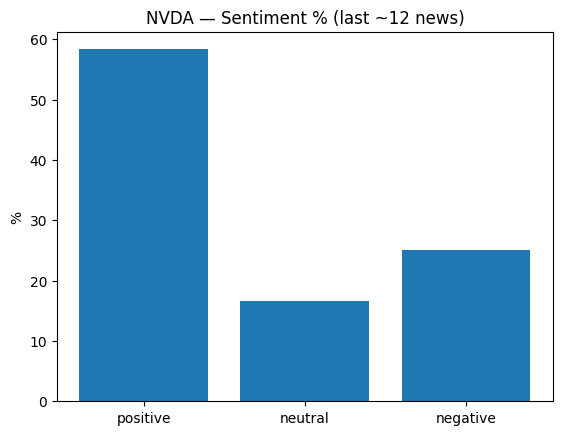

In [45]:
#Cell 17 — Simple sentiment visualization for the rubric
#Shows % positive/neutral/negative from the latest analysis

import matplotlib.pyplot as plt

sym = "NVDA"
res = optimize_news(sym, analyze_news(sym, limit=12))
pct = res["report"]["sentiment_pct"]

plt.figure()
plt.bar(["positive", "neutral", "negative"],
        [pct.get("positive", 0), pct.get("neutral", 0), pct.get("negative", 0)])
plt.title(f"{sym} — Sentiment % (last ~12 news)")
plt.ylabel("%")
plt.show()
